# Day_086

### 練習時間
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras import optimizers
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

### 設定 save_best_only True, False 的差異

In [5]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128]):
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units = n_units, 
                      activation = "relu", 
                      name = "hidden_layer" + str(i+1))(x)
            x = BatchNormalization()(x)
    
    output = Dense(units = output_units, activation = "softmax", name = "output")(x)
    
    model = Model(inputs = [input_layer], outputs = [output])
    return model

In [6]:
def plt_model_result(result):
    num_colors = len(result.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1. * i/num_colors) for i in range(num_colors)]
    
    plt.figure(figsize=(16, 9))
    for i, cond in enumerate(result.keys()):
        plt.plot(range(len(result[cond]['train-loss'])), result[cond]['train-loss'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-loss'])), result[cond]['valid-loss'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.title("Loss")
    plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure(figsize=(16, 9))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(result[cond]['train-acc'])), result[cond]['train-acc'], '-', label = 'train-' + cond, color = color_bar[i])
        plt.plot(range(len(result[cond]['valid-acc'])), result[cond]['valid-acc'], '--', label = 'valid-' + cond, color = color_bar[i])
    plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.title("Accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
results = {}
for save_best_only in [True, False]:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape = x_train.shape[1:])
    model.summary()
    optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

    if save_best_only == True:
        model_ckpt = ModelCheckpoint(filepath = "./Day_086HW.h5", monitor = "val_loss", save_best_only = True)
        model.fit(x_train, y_train, 
                  epochs = EPOCHS, 
                  batch_size = BATCH_SIZE, 
                  validation_data = (x_test, y_test), 
                  shuffle = True,
                  callbacks = [model_ckpt]
                 )
    else:
        model_ckpt = ModelCheckpoint(filepath = "./Day_086HW.h5", monitor = "val_loss", save_best_only = False)
        model.fit(x_train, y_train, 
                  epochs = EPOCHS, 
                  batch_size = BATCH_SIZE, 
                  validation_data = (x_test, y_test), 
                  shuffle = True,
                  callbacks = [model_ckpt]
                 )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    # Load back
    model = keras.models.load_model("./Day_086HW.h5")
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    
    exp_name_tag = f'save_best_only : {str(save_best_only)}'
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             'loss_loadback': loss_loadback,
                             'acc_loadback': acc_loadback}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 31s 615us/step - loss: 0.5283 - acc: 0.8463 - val_loss: 1.6254 - val_acc: 0.4921
Epoch 50/50
10000/10000 [==============================] - 5s 486us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_

Epoch 47/50
50000/50000 [==============================] - 31s 612us/step - loss: 0.5476 - acc: 0.8410 - val_loss: 1.6540 - val_acc: 0.4891
Epoch 48/50
50000/50000 [==============================] - 30s 609us/step - loss: 0.5323 - acc: 0.8459 - val_loss: 1.6356 - val_acc: 0.4901
Epoch 49/50
50000/50000 [==============================] - 30s 610us/step - loss: 0.5162 - acc: 0.8542 - val_loss: 1.6359 - val_acc: 0.4945
Epoch 50/50
10000/10000 [==============================] - 5s 483us/step


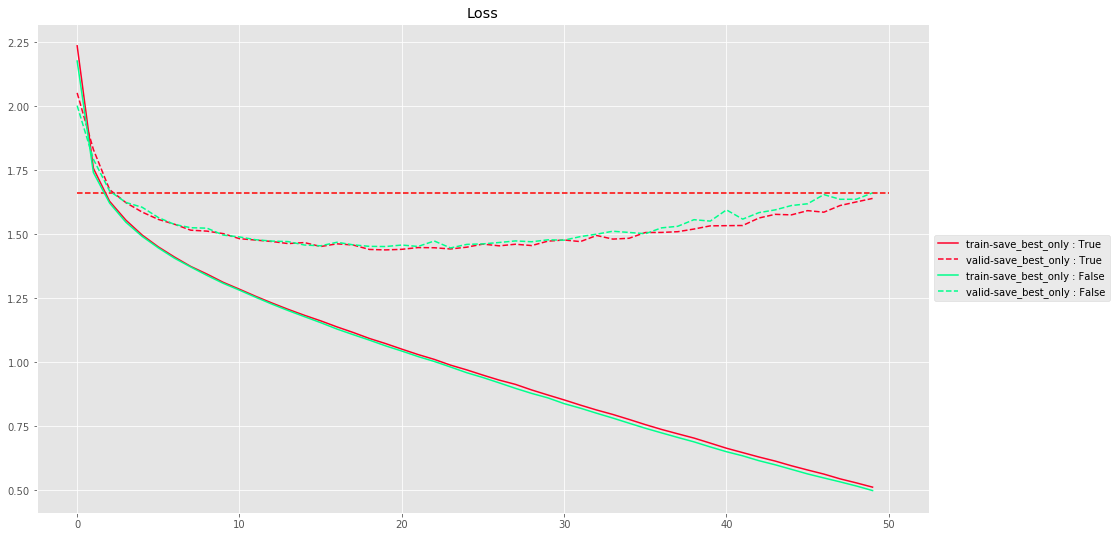

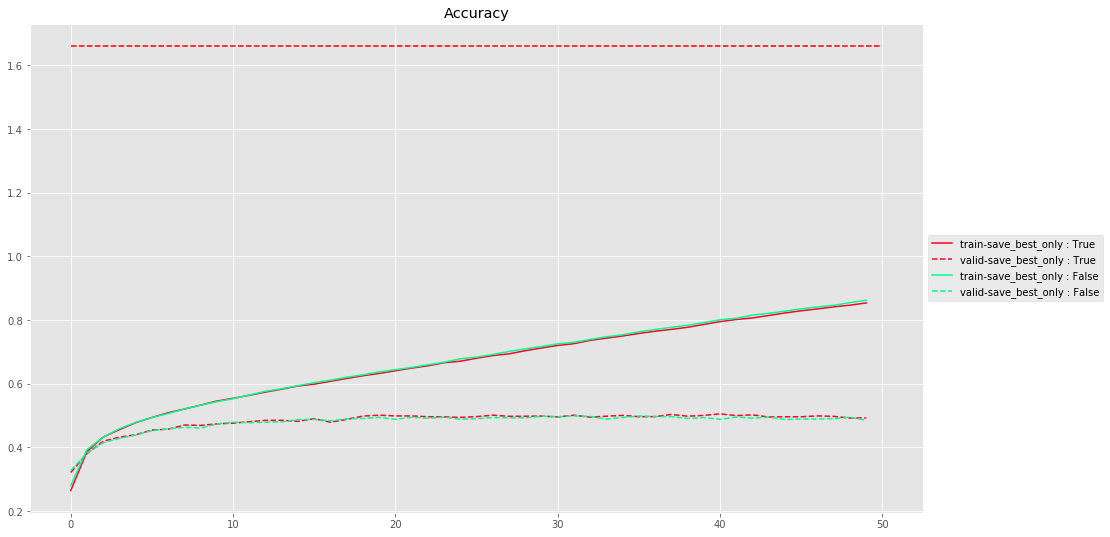

In [9]:
plt_model_result(results)

### 將 save_weights_only 設定為 True, 並嘗試 reset ipynb 將模型與權重重新建回並預測 x_test

In [10]:
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp(input_shape = x_train.shape[1:])
model.summary()
optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)
model_ckpt = ModelCheckpoint(filepath = "./Day_086HW.h5",
                             monitor = "val_loss", 
                             save_best_only = False,
                             save_weights_only = True
                            )
model.fit(x_train, y_train,
          epochs = EPOCHS,
          batch_size = BATCH_SIZE, 
          validation_data = (x_test, y_test),
          shuffle = True,
          callbacks = [model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 31s 623us/step - loss: 0.5055 - acc: 0.8591 - val_loss: 1.6439 - val_acc: 0.4932
Epoch 50/50
50000/50000 [==============================] - 31s 630us/step - loss: 0.4925 - acc: 0.8623 - val_loss: 1.6866 - val_acc: 0.4907


In [11]:
keras.backend.clear_session()

# create new model
model = build_mlp(input_shape=x_train.shape[1:])

# Load back weight of model 
model.load_weights("./Day_086HW.h5")
model.summary()

# compile new model with old weight
optimizer = optimizers.SGD(lr = LEARNING_RATE, nesterov = True, momentum = MOMENTUM)
model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = optimizer)

# using new model to predict
model.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

array([[9.8230829e-03, 3.2161564e-01, 1.5378332e-03, ..., 1.5514126e-04,
        4.0645134e-01, 1.6299193e-04],
       [5.3540175e-03, 1.3898864e-02, 3.3260339e-03, ..., 4.3753721e-04,
        8.1026381e-01, 1.6292515e-01],
       [5.7667249e-01, 1.0126068e-01, 1.9609144e-02, ..., 3.8761120e-02,
        1.7063327e-01, 8.5776150e-02],
       ...,
       [8.5790723e-04, 5.0102099e-04, 7.3962367e-01, ..., 1.5011354e-03,
        4.5482097e-03, 1.6249025e-04],
       [1.1338969e-01, 8.2846038e-02, 1.0085343e-02, ..., 6.7548999e-03,
        1.4828885e-02, 2.2122601e-02],
       [5.5307699e-03, 1.5972380e-04, 1.7896285e-02, ..., 6.8564868e-01,
        1.0524885e-03, 9.6395947e-03]], dtype=float32)